## Clasificación desde la Econometría
>
### Introducción
>En esta semana estudiaremos el problema de clasificación en Data Science, que busca esclarecer sobre los efectos que tienen los atributos en una variable categórica.
>
>Siguiendo la taxonomía de Hastie, Tibshinari y Friedman (2009), los problemas de clasificación corresponden a un ejemplo de aprendizaje supervisado donde el vector objetivo responde a un atributo discreto. Ejemplos de ello:
>
>● Movimientos del mercado: ¿Bajará o subirá la bolsa? $Y\iota \in \{0:Baja, 1:sube\}$
>
>● Clasificación de Spam: ¿Es este mail Spam o No? $p - values \leq .025 Y\iota \in 0:No, 1:Si$
>
>● Optimización de Preferencias: ¿Es más probable votar o no? $Y\iota \in 0:NoVota, 1:SiVota$
>
>Los ejemplos mencionados hacen referencia a un problema de clasificación binario, donde observamos la presencia o ausencia de un atributo. La aproximación de este fenómeno toma forma en un ensayo de Bernoulli.

In [29]:
# Importamos la triada clásica
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# seaborn
import seaborn as sns
# scipy stats para simular
import scipy.stats as stats
# statsmodels para modelación
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import lec6_graphs as gfx
plt.style.use('seaborn') # Gráficos estilo seaborn
# plt.rcParams["figure.figsize"] = (6, 3) # Tamaño gráficos
# plt.rcParams["figure.dpi"] = 200 # resolución gráficos
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Estimando probabilidades de éxito y fracaso
>
>La tarea de esta lectura es el uso de pozos de agua en Bangladesh. Resulta que el agua en Bangladesh y otros países del Sudeste Asiático está contaminada con arsénico natural. El riesgo del arsénico como cancerígeno y catalizador de otras enfermedades aumenta con la exposición prolongada. El gobierno de Bangladesh inició una estrategia nacional para la mitigación de riesgos asociados al arsénico. Una de las estrategias era el incentivar el uso compartido de pozos de napa subterránea, dado que presentan tasas de arsénico sustancialmente menores.
>
>Usaremos una base de datos donde se registró si un hogar comenzó a utilizar un nuevo pozo de napa subterránea o no. Así, clasificaremos como 1 si el hogar se cambió a un pozo nuevo, 0 de lo contrario. Analizaremos la probabilidad de cambiarse o no en función a las siguientes variables:
>
>1. La distancia del hogar al pozo más cercano (medida en 100 metros) (dist100).
>
>2. El nivel de arsénico del actual pozo en uso del hogar (arsenic).
>
>3. El nivel educacional de el/la jefe/a de hogar (educ4).
>
>4. Si algún miembro de la familia participa o no en asociaciones comunitarias (assoc).
>
##### Importamos la base de datos con pandas.


In [30]:
# ingresamos la base de datos
df = pd.read_csv('datasets/wells.csv')
# La base de datos incluye una columna de índice. Eliminemosla para evitar futuros conflictos
df = df.drop("index", axis =1)
df.head()

,y,dist100,arsenic,educ4,assoc
0,1,0.16826,2.36,0.0,0
1,1,0.47322,0.71,0.0,0
2,0,0.20967,2.07,2.5,0
3,1,0.21486,1.15,3.0,0
4,1,0.40874,1.10,3.5,1


##### Análisis exploratorio
##### La base de datos se compone de 3020 observaciones y cinco columnas.


In [31]:
print(f'La base de datos tiene {df.shape[0]} observaciones y  {df.shape[1]} columnas')
print(f'Las variables de la base de datos son {df.columns}')

La base de datos tiene 3020 observaciones y  5 columnas
Las variables de la base de datos son Index(['y', 'dist100', 'arsenic', 'educ4', 'assoc'], dtype='object')


>Solicitemos las medidas descriptivas de los datos con los que vamos a trabajar. Como ya sabemos que el método describe de pandas funciona sólo con las columnas numéricas, utilizaremos value_counts para las columnas con atributos discretos.
>
>Esto lo implementamos en un for con un if para diferenciar si los atributos tiene más de dos niveles.

In [32]:
for i in df:
    if len(df[i].value_counts()) > 2:
        print(df[i].describe(), '\n')
    else:
        print(df[i].value_counts('%'), '\n')

1    0.575166
0    0.424834
Name: y, dtype: float64 

count    3020.000000
mean        0.483319
std         0.384787
min         0.003870
25%         0.211172
50%         0.367615
75%         0.640410
max         3.395310
Name: dist100, dtype: float64 

count    3020.000000
mean        1.656930
std         1.107387
min         0.510000
25%         0.820000
50%         1.300000
75%         2.200000
max         9.650000
Name: arsenic, dtype: float64 

count    3020.000000
mean        1.207119
std         1.004329
min         0.000000
25%         0.000000
50%         1.250000
75%         2.000000
max         4.250000
Name: educ4, dtype: float64 

0    0.577152
1    0.422848
Name: assoc, dtype: float64 



In [33]:
df.describe()

,y,dist100,arsenic,educ4,assoc
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000
mean,0.575166,0.483319,1.656930,1.207119,0.422848
std,0.494400,0.384787,1.107387,1.004329,0.494093
min,0.000000,0.003870,0.510000,0.000000,0.000000
25%,0.000000,0.211172,0.820000,0.000000,0.000000
50%,1.000000,0.367615,1.300000,1.250000,0.000000
75%,1.000000,0.640410,2.200000,2.000000,1.000000
max,1.000000,3.395310,9.650000,4.250000,1.000000


>Respecto a las variables con atributos discretos (nuestra variable dependiente y, y assoc), observamos que alrededor del 58% de las familias componentes de la muestra se cambiaron de pozo a uno más seguro. Encontramos lo opuesto con assoc, cerca del 58% de los jefe de hogar en la familia no participan en asociaciones comunitarias. El nivel educacional de los encuestados se mide en el máximo grado académico desde 0 (Sin educación formal) a 4 (Secundaria completa). La media reportada sugiere que gran parte de la población posee niveles bajos de educación.
>
>La mayoría de las familias se sitúan en una distancia de 48 metros de un pozo seguro, y el nivel de arsénico promedio en el agua es de 1.65, entre el rango de .51 y 9.65, lo cual es relativamente bajo.
>
>Para tener una mejor perspectiva del comportamiento de las columnas, vamos a graficarlas con histogramas para las continuas y gráficos de barra para las discretas.

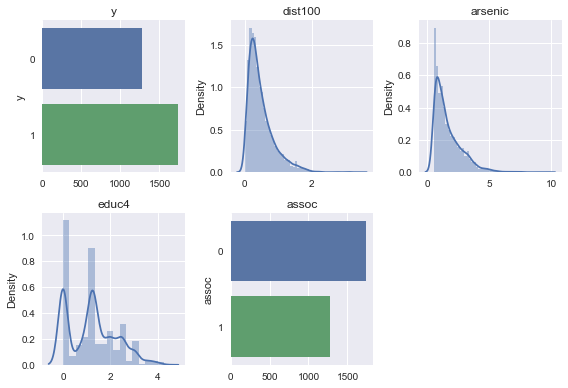

In [34]:
for n, i in enumerate(df):
    plt.subplot(2, 3, n+1)
    if len(df[i].value_counts()) > 2:
        sns.distplot(df[i])
        plt.title(i)
        plt.xlabel('')
    else:
        sns.countplot(y=df[i])
        plt.title(i)
    plt.xlabel('')
    plt.tight_layout()

>Observamos que para dist100, arsenic y educ4 existe un sesgo hacia los valores bajos, lo cual sugiere que los casos donde la distancia y el nivel de arsénico son sustancialmente grandes son relativamente anómalos.
>
>Respecto a las variables discretas, observamos que las clases están relativamente bien equilibradas, lo cual facilita nuestra modelación.
>
>Digresión: ¿Qué hacer ante clases desbalanceadas?
>
>Existe una serie de mecanismos alternativos para mitigar el efecto del desbalance en las clases:
>
>1. Asumir que el componente estocástico del modelo se puede representar de mejor manera mediante una distribución Poisson, Binomial Negativa o Cero Dispersa.
>
>2. Utilizar errores robustos (Huber-White sandwich) para fortalecer la matriz de varianza-covarianza.
>
>3. Estimar el modelo con robit (regresión logística t-distribuída) por sobre logit.
>
>4. Recolectar más datos en la medida que sea posible.
>
>5. Remuestrear sobre la muestra para disminuir el desbalance:
>
>>○ Over-sampling: Remuestrear copias de la clase sub-representada a la muestra original.
>>
>>○ Under-sampling: Eliminar instancias de la clase sobrerrepresentada.
>
>Ahora visualizamos las correlaciones mediante una matriz. Seaborn presenta el método sns.heatmap() para generar un gráfico sobre la intensidad de las asociaciones entre las variables de una base de datos. Los parámetros ingresados son:
>
>1. df.corr() ingresamos las correlaciones calculadas mediante pandas.
>
>2. cmap = 'Blues' define el rango de colores. En este caso utilizaremos una gama de azules.
>
>3. annot = True añadirá el puntaje de la correlación sobre cada celda.


<AxesSubplot:>

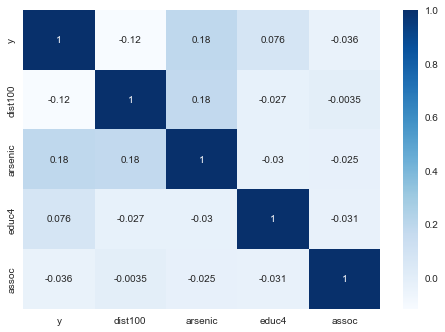

In [35]:
sns.heatmap(df.corr(), cmap='Blues', annot=True)

>Los resultados de la matriz de correlación pueden ser desalentadores, dado que no hay asociaciones fuertes entre las variables. Por defecto utilizamos la correlación de pearson,
que no tiene un buen desempeño con variables que no sean estrictamente normales. Como ya se ha mencionado antes, esto no es un impedimento para seguir con la modelación ya que muchas relaciones no son estrictamente lineales. 
>
### El modelo de probabilidad lineal
>
>Una primera aproximación al problema de clasificación binario es utilizar una regresión lineal, asumiendo que en nuestra variable dependiente estaremos midiendo la probabilidad del suceso.

$$Y_i = \beta_0 + \beta_1 \times dist100 + \varepsilon_i$$
>
>Este modelo se conoce como modelo de probabilidad lineal, donde implementamos una regresión lineal con nuestra variable dependiente binaria. Los parámetros estimados afectan la probabilidad de que el evento suceda. Con nuestro $\hat{Y}$   predicho podemos clasificar una
observación como 1 si $\hat{Y}$ > que 0.5, de lo contrario 0

In [36]:
# ejecutemos nuestro modelo
m1_ols = smf.ols('y ~ dist100', df).fit()

>Ahora vamos a generar una función para obtener sólo los parámetros necesarios en nuestro modelo. La función concise_summary() necesita como argumento el modelo estimado con statsmodels y devolverá sólo algunas características esenciales del modelo.

In [37]:
def concise_summary(mod, print_fit=True):
#guardamos los parámetros asociados a estadísticas de ajuste
    fit = pd.DataFrame({'Statistics': mod.summary2().tables[0][2][2:], 'Value': mod.summary2().tables[0][3][2:]})
# guardamos los parámetros estimados por cada regresor.
    estimates = pd.DataFrame(mod.summary2().tables[1].loc[:, 'Coef.':'Std.Err.'])
# imprimir fit es opcional
    if print_fit is True:
        print('\nGoodness of Fit statistics\n', fit)
        print('\nPoint Estimates\n\n', estimates)
# solicitemos las características del modelo
concise_summary(m1_ols)



Goodness of Fit statistics
             Statistics      Value
2                 BIC:  4288.4686
3      Log-Likelihood:    -2136.2
4         F-statistic:      42.57
5  Prob (F-statistic):   7.95e-11
6               Scale:    0.24111

Point Estimates

               Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225


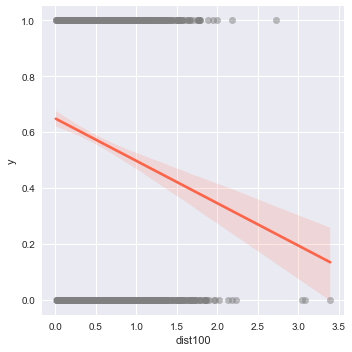

In [38]:
sns.lmplot('dist100','y', df,
line_kws={'color':'tomato'},
scatter_kws={'color': 'grey', 'alpha': .5})

In [39]:
m1_logit = smf.logit('y ~ dist100', df).fit()
concise_summary(m1_logit)

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4

Goodness of Fit statistics
         Statistics       Value
2             BIC:   4092.2639
3  Log-Likelihood:     -2038.1
4         LL-Null:     -2059.0
5     LLR p-value:  9.7978e-11
6           Scale:      1.0000
7                             

Point Estimates

               Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


In [40]:
# guardamos la media en un objeto
dist100_mean = df['dist100'].mean()
print("La media es de ", round(dist100_mean, 2))
# accedemos a los parámetros con la sintáxis modelo.params['parametro]
estimate_y = m1_logit.params['Intercept'] + (m1_logit.params['dist100']
* dist100_mean)
print("El log odds estimado es de ", round(estimate_y, 2))


La media es de  0.48
El log odds estimado es de  0.31


In [41]:
def invlogit(x):
    return 1 / (1+np.exp(-x))
print(f'La probabilidad promedio de cambiarse de pozo cuando tenemos una distancia de 48 metros es: {round(invlogit(estimate_y), 2)}')


La probabilidad promedio de cambiarse de pozo cuando tenemos una distancia de 48 metros es: 0.58


In [42]:
pr_dist_100 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 1))
pr_dist_200 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 2))
pr_dist_300 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 3))
pr_dist_400 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 4))


In [43]:
print(f'La probabilidad de cambiar de pozo entre 100 y 200 metros:  {round(pr_dist_100 - pr_dist_200, 3)}')
print(f'La probabilidad de cambiar de pozo entre 200 y 300 metros:  { round(pr_dist_200 - pr_dist_300, 3)}')
print(f'La probabilidad de cambiar de pozo entre 300 y 400 metros:  {round(pr_dist_300 - pr_dist_400, 3)}')


La probabilidad de cambiar de pozo entre 100 y 200 metros:  0.15
La probabilidad de cambiar de pozo entre 200 y 300 metros:  0.125
La probabilidad de cambiar de pozo entre 300 y 400 metros:  0.089


Una observación tiene igual probabilidad en ambos sucesos cuando x =  0.974


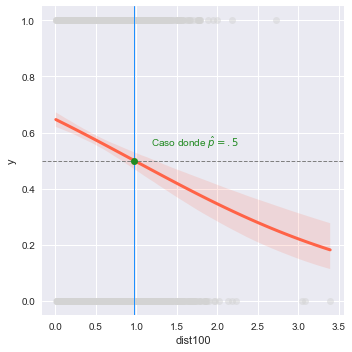

In [44]:
sns.lmplot('dist100', 'y', df, logistic=True, line_kws={'color':'tomato', 'lw': 3}, scatter_kws={'color': 'lightgrey', 'alpha': .5})
decision_boundary = - m1_logit.params['Intercept'] / m1_logit.params['dist100']
plt.axvline(decision_boundary, lw=1, color='dodgerblue')
plt.axhline(.5, linestyle='--', color='grey', lw=1)
plt.text(decision_boundary+.2, .5+.05, r'Caso donde $\hat{p}=.5$', color='forestgreen')
plt.plot(decision_boundary, .5, 'o', color='forestgreen')
print("Una observación tiene igual probabilidad en ambos sucesos cuando x = ", round(decision_boundary, 3))


In [45]:
print("\nOLS")
concise_summary(m1_ols, print_fit=False)
print("\nLogit")
concise_summary(m1_logit, print_fit=False)



OLS

Logit


In [46]:
print("La probabilidad de cambiar de pozo entre 100 y 200 metros: ", round(pr_dist_100 - pr_dist_200, 3))


La probabilidad de cambiar de pozo entre 100 y 200 metros:  0.15


In [47]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'dist100':'assoc'],df['y'],test_size=.33,random_state=11238)


In [49]:
from sklearn.preprocessing import StandardScaler
# estandarizamos la matriz de entrenamiento
X_train_std = StandardScaler().fit_transform(X_train)
# estandarizamos la matriz de pruebas
X_test_std = StandardScaler().fit_transform(X_test)
# iniciamos el modelo con la clase LogisticRegression y pasamos los datos en fit.
default_model = LogisticRegression().fit(X_train_std, y_train)


In [50]:
default_model.coef_

array([[-0.33266754,  0.5907759 ,  0.14256382, -0.05195545]])

In [51]:
yhat = default_model.predict(X_test_std)
# solicitemos las primeras 20 observaciones del vector predicho.
yhat[:20]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
      dtype=int64)